* THIS IS THE MICROGRAD NOTEBOOK TO DESIGN A SINGLE NEURON *

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Equations:

- Form: A linear equation in two variables (x and y) typically takes the form y=mx+b, where m is the slope and b is the y-intercept.
- Graphical Representation: When graphed, linear equations produce a straight line. The slope m determines the steepness and direction of this line, while the y-intercept b determines where the line crosses the y-axis.
- Characteristics: Linear equations represent a constant rate of change, meaning the slope is the same at all points on the line.
Parabolic Equations:

- Form: Parabolic equations are represented by quadratic functions, typically in the form y=ax2+bx+c, where a, b, and c are constants, and a is non-zero.
- Graphical Representation: When graphed, quadratic functions form a parabola. The value and sign of a determine whether the parabola opens upwards (if a>0) or downwards (if a<0).
- Characteristics: Parabolas represent a variable rate of change, evident in the curved shape of the graph. The rate of change increases or decreases as you move away from the vertex of the parabola.

In [3]:
# define a quadratic equation function
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

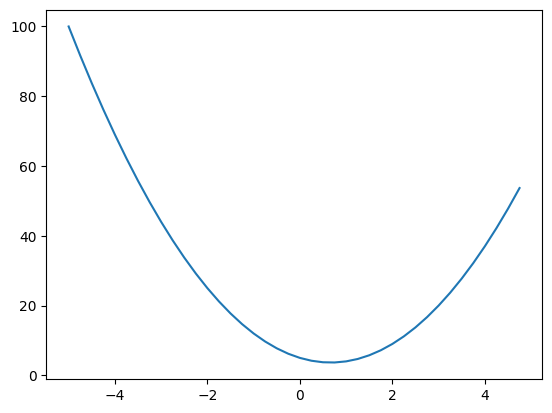

In [5]:
# for a range of values, plot x vs y
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

https://en.wikipedia.org/wiki/Derivative

In [12]:
# lets assume h is a small change in the function, how does it effect the function, +tive or -tive (a.k.a derivative) (derivative of the function w.r.t x)
h = 0.000001
x = -3
print(f(x))
(f(x+h) - f(x))/h #rise/run
print(f(x+h))

44
43.999978000003


In [13]:
# lets get more complex by adding more scalars
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [15]:
# lets work on getting the derivate of d w.r.t a, b and c

h = .0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [184]:
# let move to nn, we should start by building basic datastructures
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # grad is initialized to 0 assuming in the beginning there is no impact of changing 'data' on the output 'L'
        self._backward = lambda: None # backward ops at each node
        self._prev = set(_children) # children is to keep the memory of previous nodes
        self._op = _op # op is the operation done on the nodes
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # (self, other) is a tuple and passed as children

        # lets define the backward at the add node (secret: from 'out' it flows into 'self' and 'other')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') # (self, other) is a tuple and passed as children
        
        # lets define the backward at the mul node (secret: out.grad a.k.a global gradient is multiplied with 
        # local gradients of 'self' and 'other', where local(self.grad) = other.data and local(other.grad) = self.data)
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward=_backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward=_backward

        return out
    
    def backward(self):
        # lets now automate the autograd based on topo

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # all the childrens are first added to the list, later o is added
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
a, b
a * b
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0); f.label = 'f'
L = d * f; L.label = 'L'

In [104]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [105]:
# time to now visualize the operations graph (bit complicated)
# lets use graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # create the root node
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        # create a fake op node
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    # todo
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


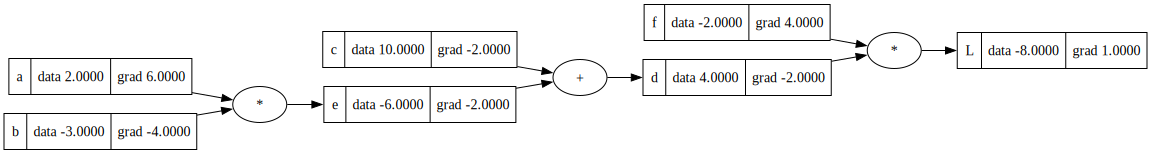

In [117]:
draw_dot(L)

The above is a forward pass, now we will work on the back propogation. Derivative of L w.r.t f, d and more. Remember the derivative of L is always w.r.t to wieghts not the input, because input is always fixed.

gradient of L w.r.t d and f

L = d * f
dL/dd = ? f

derivate -> (f(x + h) - f(x))/h
therefore, 
((d + h) * f - d * f)/h = (d*f + h*f - d*f)/h = f

similarily, dL/df = d



gradient of L w.r.t c and e (very important step)
directly we cannot calculate this, but we know how L is sensitive to d and how d will be sensitive to e and h. basically we need to know
, the impact c or e will have on d!

these are also known as local derivative
dd/dc = ? = 1.0
dd/de = 1.0

d = c + e
((c + h) + e - (c + e))/h = (c + h + e - c - e)/h = 1.0 "for + nodes the local dervivative is 1.0"

not we need to calculate dL/dc and dL/de, time to use calculus - chain rule (https://en.wikipedia.org/wiki/Chain_rule)
As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."[1]
intermidiate rate of changes are multiplied

dL/de = (dL / dd) * (dd / de) = -2.0 * 1.0 = -2.0
dL/dc = (dL / dd) * (dd / dc) = -2.0 * 1.0 = -2.0

in a '+' node, the gradient just transits to previous nodes.

gradient of L w.r.t a and b

grad = f(x+h) - f(x)/h

e = a * b
de/da = ? = b
de/db = ? = a

f((a+h) * b - f(a * b))/h = ab + hb - ab = hb/h = b
f(a * (b + h) - f(a * b))/h = ab + ah - ab = ah/h = a

dL/da = dL/de * de/da = -2.0 * -3.0 = 6.0
dL/db = dL/de * de/db = -2.0 * 2.0 = -4.0

In [115]:
# gradient of L w.r.t L
L.grad = 1.0

# gradient of L w.r.t to f and d (refer above)
f.grad = 4.0
d.grad = -2.0

c.grad = -2.0
e.grad = -2.0

a.grad = 6.0
b.grad = -4.0

In [116]:
# lets start filling the gradient above, create a local scope for the variables
# also called finding inline gradients
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0); f.label = 'f'
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    #a.data += h
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    #e.data += h
    d = e + c; d.label = 'd'
    #d.data += h
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-3.9999999999995595


In [118]:
# lets try to increase L positively, by nudging the nodes
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * d.grad

# lets run the forward pass
e = a * b
d = e + c
L = d * f

print(L.data)


-7.509552


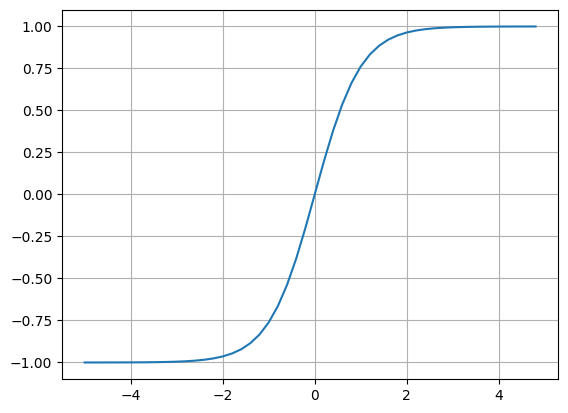

In [119]:
# refer to the neuron structure here https://www.google.com/search?sca_esv=587070021&rlz=1C5CHFA_enGB1040GB1040&sxsrf=AM9HkKmWvSuIOfYfbLumOLjOrNzFB8QV7g:1701465789244&q=cs231n&tbm=isch&source=lnms&sa=X&sqi=2&ved=2ahUKEwjpm9z_le-CAxXCRPEDHafsCtUQ0pQJegQICxAB&biw=1470&bih=803&dpr=2#imgrc=nB3TZGcSKocD7M

# neuron accepts inputs, which are multiplied by weights on synapses, followed by a summation and addition of bias, bias is to add or remove happiness
# after which we apply an activation function to smoothen the inputs like tanh below

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))) # inputs ranging from -5 to 5 is smoothen between -1 and 1
plt.grid()

# activation function is also known as squashing function

In [172]:
# lets develop a neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#draw_dot(n)

# we will now apply activation function - tanh, but tanh cannot be applied on +*, since tanh is hyperbolic function we will need exponensiation
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# tanh x = sinh x\cosh x = e^{x}-e^{-x} / e^{x}+e^{-x}= e^{2x}-1 / e^{2x}+1

o = n.tanh(); o.label='o'

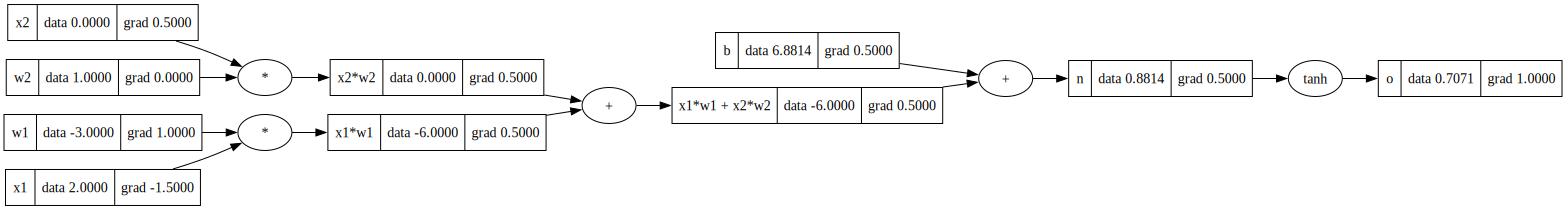

In [175]:
# lets check with autograd
draw_dot(o)

In [174]:
# finally call the main backward func
o.backward()

In [156]:
# lets check with autograd
# output grad should be initialized to 0 for getting started
o.grad = 1.0

In [164]:
# lets check with autograd
o._backward()

n._backward()

x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()



In [166]:
# now finally lets make the backward operation automatic, but before we do that, remember that the graph is complete
# we are going to use topological sort - https://www.google.com/search?sca_esv=587936899&rlz=1C5CHFA_enGB1040GB1040&sxsrf=AM9HkKkgNl1LYgIUXSoaETQPaoB05UQEig:1701757921357&q=topological+sort&tbm=isch&source=lnms&sa=X&sqi=2&ved=2ahUKEwi8npWj1veCAxXMQEEAHZfsAE8Q0pQJegQIDBAB&biw=1470&bih=803&dpr=2#imgrc=hTeadWFDSdY21M 
# goal is that all edges go in one direction i.e. left to right e.g.

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # all the childrens are first added to the list, later o is added
build_topo(o)
topo


[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [169]:
# lets now automate the autograd based on topo
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) # all the childrens are first added to the list, later o is added
build_topo(o)

for node in reversed(topo):
    node._backward()


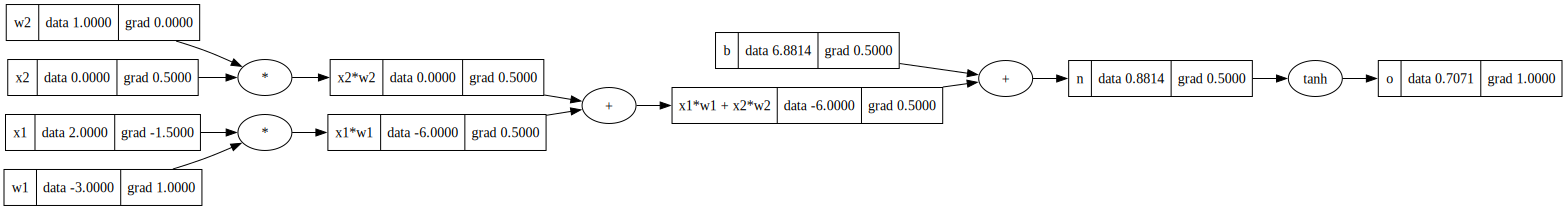

In [141]:
draw_dot(o)

In [140]:
# lets start backpropogation for the above neuron

o.grad = 1.0

# we will have to take local derivative of tanh, refer to the wiki page for the formula
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2 = 1 - o.data**2
n.grad = 1 - o.data**2
n.grad = 0.5

# since next nodes are next to additive, the gradient just flows
b.grad = 0.5
x1w1x2w2.grad = 0.5

# since next nodes are also next to additive, the gradient just flows
x1w1.grad = 0.5
x2w2.grad = 0.5

# at multiply ops the swap happens for gradients i.e.
# x2w2 = x2 * w2
# dx2w2/dx2 = w2
# dx2w2/dw2 = x2
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
# similarily for x1 and w1
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


now is the time to automate all of the above into autograd, go up and add a backward op to the Value datastructure

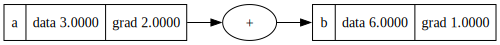

In [185]:
# lets fix the bug in our datastructure
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

# BUG: the grad of 'a' should be 2.0


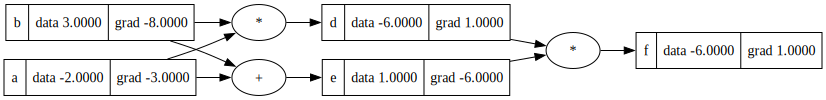

In [186]:
# another way to look at the bug, anytime we use a value multiple times, it gets overwritten in backward pass
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'

f.backward()

draw_dot(f)

# fun part below if that grad of 'a' and 'b' are overwritten during the backward pass at '*' and '+' ops

# Solution: multivariate case of chain rule, we have to accumulate the gradients and add